# Setup

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [3]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

model_path = 'densenetSoftAtt_10split_LRStr.hdf5'

In [4]:
target_size = (224, 224)
def Get_data(df_path, img_path, _target_size):
    img_list = []
    labels = []
    ages = []
    sex_list = []
    localizations = []
    
    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['image_id'] + '.jpg'))
        labels.append(row['dx'])
        ages.append(float(row['age']))
        sex_list.append(row['sex'])
        localizations.append(row['localization'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size)
        img_list[x] = tf.keras.applications.mobilenet.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return (img_list, ages, sex_list, localizations), labels

In [5]:
train_df = pd.read_csv(train_label)
train_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,0,ISIC_0027419,bkl,80.0,male,scalp
1,1,ISIC_0025030,bkl,80.0,male,scalp
2,2,ISIC_0026769,bkl,80.0,male,scalp
3,3,ISIC_0025661,bkl,80.0,male,scalp
4,4,ISIC_0031633,bkl,75.0,male,ear


In [6]:
val_df = pd.read_csv(val_label)
val_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,2973,ISIC_0031531,bcc,70.0,male,back
1,483,ISIC_0026526,bkl,60.0,male,face
2,8870,ISIC_0026805,nv,75.0,female,lower extremity
3,1991,ISIC_0030756,mel,85.0,male,chest
4,8324,ISIC_0024834,nv,70.0,male,chest


## Training Data

In [7]:
(train_img_lst, train_ages, train_sexes, train_localizations), labels = Get_data(train_label, main_img_dir, target_size)

In [8]:
any(elem is None for elem in train_img_lst)

False

In [9]:
print("Number of images: {}".format(len(train_img_lst)))
print("Image shape: {0} {1}".format(train_img_lst[0].shape[0], train_img_lst[0].shape[1]))
print("Example of Age: {}".format(train_ages[0]))
print("Example of Sex: {}".format(train_sexes[0]))
print("Example of Localization: {}".format(train_localizations[0]))

Number of images: 8962
Image shape: 224 224
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


## Validation Data

In [10]:
(val_img_lst, val_ages, val_sexes, val_localizations), val_labels = Get_data(val_label, main_img_dir, target_size)

In [11]:
any(elem is None for elem in val_img_lst)

False

In [12]:
print("Number of images: {}".format(len(val_img_lst)))
print("Image shape: {0} {1}".format(val_img_lst[0].shape[0], val_img_lst[0].shape[1]))
print("Example of Age: {}".format(val_ages[0]))
print("Example of Sex: {}".format(val_sexes[0]))
print("Example of Localization: {}".format(val_localizations[0]))

Number of images: 996
Image shape: 224 224
Example of Age: 70.0
Example of Sex: male
Example of Localization: back


# Model

## Input Block

In [13]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32)
sex_input = tf.keras.Input(shape=(1,), name='sex', dtype=tf.string)
localizations_input = tf.keras.Input(shape=(1,), name='localization', dtype=tf.string)

inputs = {'age' : age_input,
         'sex' : sex_input,
         'local' : localizations_input}

In [14]:
norm = layers.Normalization()
norm.adapt(np.array(train_df[['age']]))
age_norm_input = norm(age_input)
age_norm_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>

In [15]:
# Sex input
sex_lookup = layers.StringLookup(vocabulary=np.unique(train_df['sex']))
sex_one_hot = layers.CategoryEncoding(num_tokens=sex_lookup.vocabulary_size())

preprocessed_sex_input = sex_lookup(sex_input)
preprocessed_sex_input = sex_one_hot(preprocessed_sex_input)
preprocessed_sex_input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding')>

In [16]:
# Localization input
local_lookup = layers.StringLookup(vocabulary=np.unique(train_df['localization']))
local_one_hot = layers.CategoryEncoding(num_tokens=local_lookup.vocabulary_size())

preprocess_local_input = local_lookup(localizations_input)
preprocess_local_input = local_one_hot(preprocess_local_input)
preprocess_local_input

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_1')>

In [17]:
preprocessed_inputs = [age_norm_input, preprocessed_sex_input, preprocess_local_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# preprocessed_Model = tf.keras.Model(inputs, preprocessed_inputs_cat)
# tf.keras.utils.plot_model(model = preprocessed_Model , rankdir="LR", dpi=72, show_shapes=True)

preprocessed_inputs_cat

<KerasTensor: shape=(None, 21) dtype=float32 (created by layer 'concatenate')>

## Soft Attention

In [18]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [19]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [20]:
densenet = tf.keras.applications.DenseNet201(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)

inputs['image'] = densenet.input

# Exclude the last 28 layers of the model.
densenet_output = densenet.layers[-28].output

## Final Model

In [21]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(densenet_output.shape[-1]),name='soft_attention')(densenet_output)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
densenet_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(densenet_output))

densenet_output = layers.Concatenate()([densenet_output, attention_layer])
densenet_output = Activation('relu')(densenet_output)
densenet_output = Dropout(0.5)(densenet_output)

In [22]:
output = Flatten()(densenet_output)
preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
preprocessed_inputs_cat = Dropout(.2)(preprocessed_inputs_cat)
output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(7, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 14, 14, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)                           )                                 'conv4_block33_2_conv[0][0]']   
          

                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_blo

 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 14, 14, 1728  6912       ['conv4_block46_concat[0][0]']   
 lization)

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 7, 7, 960)   0           ['conv5_block1_concat[0][0]',    
 te)      

 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 7, 7, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 7, 7, 128)    192512      ['conv5_block20_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 7, 7, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
          

## Training

In [24]:
feature_dict = {'age' : np.array(train_ages),
                'sex' : np.array(train_sexes),
                'local' : np.array(train_localizations),
                'image' : np.array(train_img_lst)}

In [25]:
val_dict = {'age' : np.array(val_ages),
                'sex' : np.array(val_sexes),
                'local' : np.array(val_localizations),
                'image' : np.array(val_img_lst)}

In [26]:
class_weights = { 
                    0: 4.37,  # akiec
                    1: 2.78,  # bcc
                    2: 1.3,  # bkl
                    3: 12.44,  # df
                    4: 1.28,  # mel
                    5: 0.21,  # nv
                    6: 10,  # vasc
                }

checkpoint=  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [27]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [29]:
batch_size = 32 

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/GPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=(len(train_df)/10),
                        epochs=500,
                        validation_data=(val_dict, val_labels), 
                        validation_steps=len(val_df)/batch_size,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/500
896/896 [==============================] - 1236s 1s/step - loss: 1.8393 - accuracy: 0.3552 - val_loss: 1.7080 - val_accuracy: 0.4398 - lr: 0.0010
Epoch 2/500
896/896 [==============================] - 998s 1s/step - loss: 1.1803 - accuracy: 0.6042 - val_loss: 0.8361 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 3/500
896/896 [==============================] - 1003s 1s/step - loss: 0.8224 - accuracy: 0.6732 - val_loss: 1.0219 - val_accuracy: 0.6426 - lr: 0.0010
Epoch 4/500
896/896 [==============================] - 1020s 1s/step - loss: 0.6293 - accuracy: 0.7225 - val_loss: 0.8228 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 5/500
896/896 [==============================] - 1041s 1s/step - loss: 0.4906 - accuracy: 0.7534 - val_loss: 0.7502 - val_accuracy: 0.7229 - lr: 0.0010
Epoch 6/500
896/896 [==============================] - 879s 980ms/step - loss: 0.3686 - accuracy: 0.7782 - val_loss: 0.5988 - val_accuracy: 0.7982 - lr: 0.0010
Epoch 7/500
896/896 [==============================

Epoch 46/500
896/896 [==============================] - 843s 940ms/step - loss: 0.0088 - accuracy: 0.9951 - val_loss: 0.3764 - val_accuracy: 0.8876 - lr: 1.0000e-07
Epoch 47/500
896/896 [==============================] - 846s 944ms/step - loss: 0.0090 - accuracy: 0.9949 - val_loss: 0.3771 - val_accuracy: 0.8906 - lr: 1.0000e-07
Epoch 48/500
896/896 [==============================] - 844s 942ms/step - loss: 0.0102 - accuracy: 0.9948 - val_loss: 0.3773 - val_accuracy: 0.8896 - lr: 1.0000e-07
Epoch 49/500
896/896 [==============================] - 840s 937ms/step - loss: 0.0097 - accuracy: 0.9958 - val_loss: 0.3776 - val_accuracy: 0.8886 - lr: 1.0000e-07
Epoch 50/500
896/896 [==============================] - 837s 933ms/step - loss: 0.0101 - accuracy: 0.9941 - val_loss: 0.3778 - val_accuracy: 0.8886 - lr: 1.0000e-07
Epoch 51/500
896/896 [==============================] - 953s 1s/step - loss: 0.0088 - accuracy: 0.9948 - val_loss: 0.3810 - val_accuracy: 0.8886 - lr: 1.0000e-07


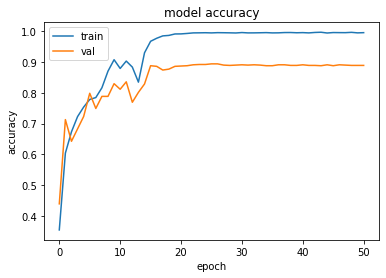

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

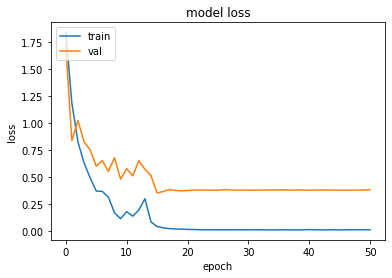

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
from tensorflow.keras import models
model.load_weights(model_path)

In [33]:
batch_size = 32 
predictions = model.predict(val_dict, steps=len(val_df)/batch_size, verbose=0)

# Classification report

In [34]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.79      0.79      0.79        33
         bcc       0.79      0.80      0.80        51
         bkl       0.83      0.87      0.85       109
          df       0.85      0.92      0.88        12
         mel       0.76      0.67      0.71       111
          nv       0.94      0.94      0.94       666
        vasc       0.82      1.00      0.90        14

    accuracy                           0.89       996
   macro avg       0.82      0.86      0.84       996
weighted avg       0.89      0.89      0.89       996



# Confusion Matrix Metrics

In [35]:
from sklearn.metrics import multilabel_confusion_matrix
multi_cm = multilabel_confusion_matrix(y_true, y_pred)
#print(multi_cm)

# TN     FP
# FN     TP

In [36]:
def cm_compute(_cm, _index, _name):
    print("Confusion Matrix of {}".format(_name))
    print(_cm[index])
    TP = _cm[index][1][1]
    FP = _cm[index][0][1]
    FN = _cm[index][1][0]
    TN = _cm[index][0][0]
    print("True Positive of {0}: {1}".format(_name, TP))
    print("False Positive of {0}: {1}".format(_name, FP))
    print("False Negative of {0}: {1}".format(_name, FN))
    print("True Negative of {0}: {1}".format(_name, TN))
    sensitivity = TP/(TP + FN)
    specificity = TN/(TN + FP)
    print("Sensitivity of {0}: {1}".format(_name, sensitivity))
    print("Specificity of {0}: {1}".format(_name, specificity))
    print("Precision of {0}: {1}".format(_name, TP/(TP + FP)))
    print("Accuracy of {0}: {1}".format(_name, (TP+TN)/(TP + FP + FN + TN)))
    print("Balanced Accuracy of {0} : {1}".format(_name, (sensitivity + specificity)/2))
    print("F1 Score of {0}: {1}".format(_name, (2*TP)/(2*TP + FP + FN)))

### akiec       

In [37]:
index = 0
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of akiec
[[956   7]
 [  7  26]]
True Positive of akiec: 26
False Positive of akiec: 7
False Negative of akiec: 7
True Negative of akiec: 956
Sensitivity of akiec: 0.7878787878787878
Specificity of akiec: 0.9927310488058152
Precision of akiec: 0.7878787878787878
Accuracy of akiec: 0.9859437751004017
Balanced Accuracy of akiec : 0.8903049183423015
F1 Score of akiec: 0.7878787878787878


### bcc       

In [38]:
index = 1
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bcc
[[934  11]
 [ 10  41]]
True Positive of bcc: 41
False Positive of bcc: 11
False Negative of bcc: 10
True Negative of bcc: 934
Sensitivity of bcc: 0.803921568627451
Specificity of bcc: 0.9883597883597883
Precision of bcc: 0.7884615384615384
Accuracy of bcc: 0.9789156626506024
Balanced Accuracy of bcc : 0.8961406784936197
F1 Score of bcc: 0.7961165048543689


### bkl

In [39]:
index = 2
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of bkl
[[867  20]
 [ 14  95]]
True Positive of bkl: 95
False Positive of bkl: 20
False Negative of bkl: 14
True Negative of bkl: 867
Sensitivity of bkl: 0.8715596330275229
Specificity of bkl: 0.9774520856820744
Precision of bkl: 0.8260869565217391
Accuracy of bkl: 0.9658634538152611
Balanced Accuracy of bkl : 0.9245058593547987
F1 Score of bkl: 0.8482142857142857


### df 

In [40]:
index = 3
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of df
[[982   2]
 [  1  11]]
True Positive of df: 11
False Positive of df: 2
False Negative of df: 1
True Negative of df: 982
Sensitivity of df: 0.9166666666666666
Specificity of df: 0.9979674796747967
Precision of df: 0.8461538461538461
Accuracy of df: 0.9969879518072289
Balanced Accuracy of df : 0.9573170731707317
F1 Score of df: 0.88


### mel

In [41]:
index = 4
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of mel
[[861  24]
 [ 37  74]]
True Positive of mel: 74
False Positive of mel: 24
False Negative of mel: 37
True Negative of mel: 861
Sensitivity of mel: 0.6666666666666666
Specificity of mel: 0.9728813559322034
Precision of mel: 0.7551020408163265
Accuracy of mel: 0.9387550200803213
Balanced Accuracy of mel : 0.819774011299435
F1 Score of mel: 0.7081339712918661


### nv

In [42]:
index = 5
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of nv
[[291  39]
 [ 37 629]]
True Positive of nv: 629
False Positive of nv: 39
False Negative of nv: 37
True Negative of nv: 291
Sensitivity of nv: 0.9444444444444444
Specificity of nv: 0.8818181818181818
Precision of nv: 0.9416167664670658
Accuracy of nv: 0.9236947791164659
Balanced Accuracy of nv : 0.9131313131313131
F1 Score of nv: 0.9430284857571214


### vasc

In [43]:
index = 6
cm_compute(multi_cm, index, targetnames[index])

Confusion Matrix of vasc
[[979   3]
 [  0  14]]
True Positive of vasc: 14
False Positive of vasc: 3
False Negative of vasc: 0
True Negative of vasc: 979
Sensitivity of vasc: 1.0
Specificity of vasc: 0.9969450101832994
Precision of vasc: 0.8235294117647058
Accuracy of vasc: 0.9969879518072289
Balanced Accuracy of vasc : 0.9984725050916496
F1 Score of vasc: 0.9032258064516129


## Weighted, Macro, Micro, ROC AUC

In [44]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8924411321673074
Recall: 0.893574297188755
Accuracy: 0.893574297188755
weighted Roc score: 0.972338720918684


In [45]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.8241184782948585
Recall: 0.8558768239016485
Accuracy: 0.893574297188755
Macro Roc score: 0.9808140083812156


In [46]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.893574297188755
Recall: 0.893574297188755
Accuracy: 0.893574297188755
Micro Roc score: 0.9902607417622296


In [47]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9902451304320463
The ROC AUC score of bcc is: 0.9933810561261541
The ROC AUC score of bkl is: 0.9833476412606146
The ROC AUC score of df is: 0.9861957994579946
The ROC AUC score of mel is: 0.9401740723774622
The ROC AUC score of nv is: 0.9725725725725726
The ROC AUC score of vasc is: 0.9997817864416643


In [48]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

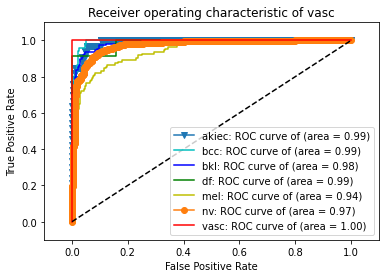

In [49]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

### 